In [1]:
import os

import librosa
import numpy as np
import pandas
import IPython

# 1. Read Audio
- Audio는 librosa를 사용하여 audio를 read.
librosa.load: [링크](https://librosa.org/doc/latest/generated/librosa.load.html?highlight=load#librosa.load)

In [2]:
example_audio_path = os.path.join('datasets', 'example', 'audio', 'acoustic_rpm_2000', 'abnormal', 'abnormal_0.wav')
sample_rate = 32000
signal, sr = librosa.load(example_audio_path, sr=sample_rate)

- .shape 함수를 이용하여 읽어온 Audio의 Dimension을 확인해 볼 수 있다.
보통 오디오의 Dimension은 (channel, samples)로 이루어져있음.

In [3]:
# 1.3초의 audio이기 때문에 41600
print("Signal shape: {}".format(signal.shape))

Signal shape: (41600,)


## Audio 들어보기
- IPython에서 제공하는 display API를 사용하여 오디오 및 진동 데이터를 들어볼 수 있다.

In [4]:
IPython.display.Audio(signal, rate=sr)

# 2. ASCII 파일 읽어오기
- ASCII 파일은 open() 함수 (File read)를 이용하여 읽어온다.

In [5]:
ex_asc_path = os.path.join('datasets', 'example', 'vibe', 'data_4_tutorial',
                           '20191023_BSA_EG112190_1 (13.00-28.00 s).asc')

ex_asc_nh_path = os.path.join('datasets', 'example', 'vibe', 'data_4_tutorial',
                              'X02VG4KNKH118202_2.asc')

sample_rate = 25600
f = open(ex_asc_path, encoding='cp949')
vibe_data_lines = f.readlines()

- Read_data_lines 함수를 직접 작성하여 각 채널의 데이터를 읽어옴.

In [6]:
NUM_HEAD_LINES = 7


def read_data_lines(lines,
                    sample_rate: int,
                    diagnosing_part: str,
                    with_header: bool = False) -> list:
    assert diagnosing_part in ['snap_ring', 'bsa']
    if not with_header:
        if diagnosing_part == 'snap_ring':
            time_duration = 5.0
            num_samples = round(time_duration * sample_rate)
            return np.array(([line.split('\t')[1:] for line in lines[-num_samples:]]), dtype=np.float32).T

        elif diagnosing_part == 'bsa':
            time_duration = 2.0
            num_samples = round(time_duration * sample_rate)
            return np.array(([line.split('\t')[1:] for line in lines[:num_samples]]), dtype=np.float32).T

        else:
            raise ValueError

    head = lines[:NUM_HEAD_LINES]
    data = lines[NUM_HEAD_LINES:]
    timestamps = [line.split('\t')[0] for line in data]

    if diagnosing_part == 'snap_ring':
        trigger_time = head[-1].split(',')[-2]
        time_duration = 5.0
    elif diagnosing_part == 'bsa':
        trigger_time = head[-1].split(',')[1]
        time_duration = 2.0
    else:
        raise ValueError

    start_idx = [i for i, ts in enumerate(timestamps) if trigger_time in ts][0]
    end_idx = int(start_idx + round(time_duration * sample_rate))
    return np.array(([line.split('\t')[1:] for line in data[start_idx:end_idx]]), dtype=np.float32).T


bsa_data = read_data_lines(vibe_data_lines, sample_rate=sample_rate, diagnosing_part='bsa', with_header=False)
snap_ring_data = read_data_lines(vibe_data_lines, sample_rate=sample_rate, diagnosing_part='snap_ring',
                                 with_header=False)

# BSA data 2초, Snap ring data 5초
print(bsa_data.shape)
print(snap_ring_data.shape)

(3, 51200)
(3, 128000)


## 진동 데이터 들어보기
- 데이터를 Numpy array 형태로 바꿔주면 어떤 데이터도 IPython에서 제공하는 display API를 사용하여 데이터를 청취해 볼 수 있다.

In [7]:
display(IPython.display.Audio(bsa_data[1], rate=sample_rate))
display(IPython.display.Audio(snap_ring_data[1], rate=sample_rate))

# 진동/음향 데이터 plot
- Python에서 자주사용하는 그래프 라이브러리인 matplotlib을 이용하여 waveform을 그려본다.

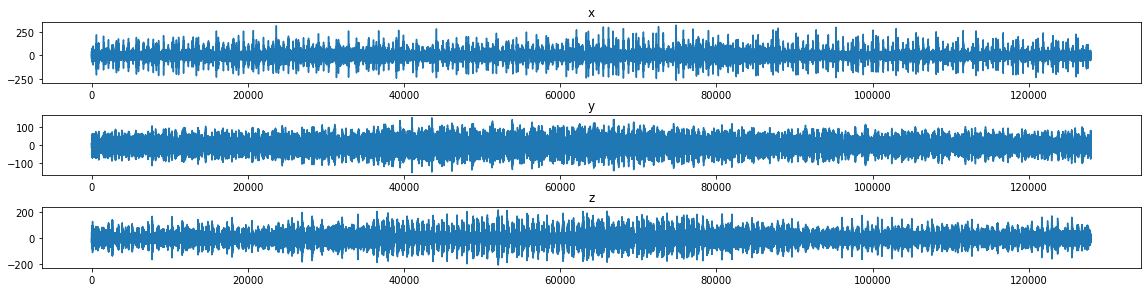

In [8]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 4))  # nrows: 행 개수, ncols: 열 개수, figsize: plot 할 이미지 크기
plt.tight_layout()  # 그래프 그림 배열

axs[0].set_title('x')
axs[0].plot(snap_ring_data[0])

axs[1].set_title('y')
axs[1].plot(snap_ring_data[1])

axs[2].set_title('z')
axs[2].plot(snap_ring_data[2])

# 데이터 전처리 (Preprocessing)
- 읽은 진동/음향 데이터를 librosa library를 이용하여 전처리를 수행한다.

## Linear Spectrogram
- librosa.stft 함수를 이용하여 linear spectrogram을 그려볼 수 있다.

(513, 501)
(513, 501)
(513, 501)


Text(0.5, 1.0, 'Spectrogram (dB)')

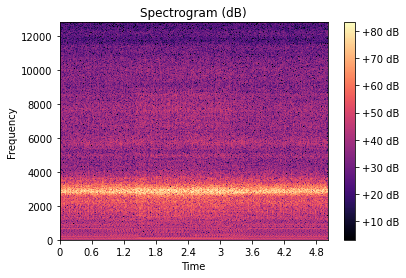

In [9]:
import librosa.display

hop_length = 256
n_fft = 1024

stft = librosa.stft(snap_ring_data[2], n_fft=n_fft, hop_length=hop_length)
print(stft.shape)

magnitude = np.abs(stft)
print(magnitude.shape)

# Power_to_db (S**2) 와 같다.
log_spectrogram = librosa.amplitude_to_db(magnitude)
print(log_spectrogram.shape)

plt.figure()
librosa.display.specshow(
    log_spectrogram,
    sr=sample_rate,
    hop_length=hop_length,
    y_axis='linear',
    x_axis='time'
)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

## Mel Spectrogram
- librosa.melspectrogram 함수를 이용하여 mel spectrogram을 그려볼 수 있다.

Text(0.5, 1.0, 'Mel-Spectrogram (dB)')

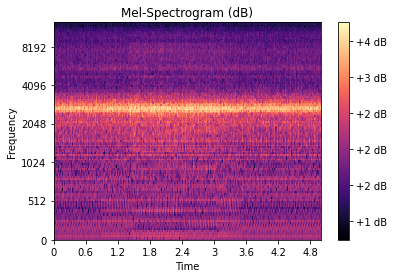

In [10]:
mel_spectrogram = librosa.feature.melspectrogram(
    S=log_spectrogram,
)
plt.figure()

librosa.display.specshow(
    mel_spectrogram,
    sr=sample_rate,
    hop_length=hop_length,
    y_axis='mel',
    x_axis='time'
)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (dB)")

- 아니면 signal로 부터 바로 Mel-spectrogram을 추출 할 수 있다.

Text(0.5, 1.0, 'Mel-Spectrogram (dB)')

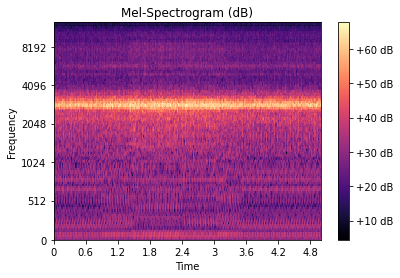

In [11]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=snap_ring_data[2],
    n_mels=128,
    n_fft=n_fft,
    hop_length=hop_length,
    sr=sample_rate,
)

# Power_to_db (S**2) 와 같다.
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
plt.figure()

librosa.display.specshow(
    log_mel_spectrogram,
    sr=sample_rate,
    hop_length=hop_length,
    y_axis='mel',
    x_axis='time'
)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (dB)")